# 10a: Particle tracking with MODFLOW 6 PRT
In this exercise, we will use the MODFLOW 6 Particle Tracking (PRT) Model to simulate advective transport with a quadtree version of the Freyberg flow model. 

The PRT Model calculates three-dimensional, advective particle trajectories in flowing groundwater. The PRT Model is designed to work with the MODFLOW 6 Groundwater Flow (GWF) Model and uses the same spatial discretization, which may be represented using either a structured (DIS) or an unstructured (DISV) grid. The PRT Model replicates much of the functionality of MODPATH 7 and offers support for a much broader class of unstructured grids. The PRT Model can be run in the same simulation as the associated GWF Model or in a separate simulation that reads previously calculated flows from a binary budget file. Currently, the PRT Model documented does not support grids of DISU type, tracking of particles through advanced stress package features such as lakes or streams reaches, or exchange of particles between PRT models.

This exercise demonstrates setting up and running the PRT Model in a separate simulation contained in a subfolder of the groundwater flow model workspace. We will also do some basic post-processing- making plots and exporting results to a GeoPackage for visualization in a GIS environment.

In [1]:
from IPython.display import clear_output, display
import os
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from flopy.utils.gridintersect import GridIntersect
import flopy


The location of the contamination patch and the nodes that the define bounding cells of the patch are calculated below.

In [2]:
# patch upper left and lower right
xmin, xmax = 250. * 1, 250. * 3
ymin, ymax = (40 - 14) * 250., (40 - 11) * 250. 

csx, csy = [xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin]
polygon = [list(zip(csx, csy))]
(xmin, ymax), (xmax, ymin)

((250.0, 7250.0), (750.0, 6500.0))

--------------------------

### Define the workspace, model names and key options.

In [3]:
load_ws = Path('data/quadtree')
gwf_ws = Path("temp/ex10a")
gwf_name = "project"
#name_mp = f"{name}_mp"
exe_name = 'mf6'

# flow model output files to use with PRT
headfile = f"{gwf_name}.hds"
budgetfile = f"{gwf_name}.cbc"

prt_name = f"{gwf_name}-prt"
prt_model_ws = gwf_ws / 'prt'

# PRT output files
budgetfile_prt = f"{prt_name}.cbc"
trackfile_prt = f"{prt_name}.trk"
trackcsvfile_prt = f"{prt_name}.trk.csv"

# if using "local_z" option
# 1=start particles at top of cell
# 0=start particles at bottom of cell
# 1 resulted in Error: release point (z=29.899951638778955) is above grid top 29.886768340000000
particle_release_zrpt = .99


## Load the MODFLOW 6 Model

Load a simulation object using `flopy.mf6.MFSimulation().load()`.

In [4]:
%%capture
sim = flopy.mf6.MFSimulation.load(sim_name=gwf_name, exe_name=exe_name,
                                  sim_ws=load_ws)

### Load the groundwater flow model

In [5]:
gwf = sim.get_model(gwf_name)
gwf.modelgrid

xll:0.0; yll:0.0; rotation:0.0; units:meters; lenuni:2

### Change the workspace
(so that we don't modify the original flow model)

In [6]:
sim.set_sim_path(gwf_ws)

### Add ``save_saturation`` and ``save_flows`` to the NPF Package
(required for PRT)

In [7]:
gwf.npf.save_saturation = True
gwf.npf.save_flows = True

### Write the model files

In [8]:
%%capture
sim.write_simulation()

### Add `IFLOWFACE=6` information to the SFR Package
This may not be necessary here because of the quadtree grid (that is refined in the stream cells), but it is often best practice.

Particle tracking with numerical models is prone to the problem of weak sinks, where a sink (flux of water leaving a cell) is not strong enough to capture all of the flow through that cell. In other words, one or more cell faces still has outward flow, allowing water to pass through the cell. By default, PRT and MODPATH assume that sinks are distributed uniformly throughout a cell (`IFLOWFACE=0` or `IFACE=0`; see below). This setting is appropriate for wells, but for surface water features (especially small streams), this often prevents particles from discharging, leading to unrealistic pathlines and travel times. Some possible solutions:
* reduce the grid size until all cells of interest are strong sinks
* set `STOP_AT_WEAK_SINK=True` in the PRT Particle Release (PRP) input (or the equivalent setting in MODPATH), causing all particles to terminate at weak sinks. This option is often not appropriate for small streams, which in many cases should act as weak sinks (only capturing the shallowest particles).\
* set `IFLOWFACE=-1` or `IFACE=6` for cells with surface water boundary conditions, to instruct PRT or MODPATH to apply the sink discharge to the top face. In cells with small (weak) streams, assuming the stream bottom corresponds to the cell top, shallow particles that are near the top of the cell will discharge, while deeper particles will be allowed to pass through realistically. Abrams and others (2013) discuss this concept in more detail.

**From the MODFLOW 6 I/O guide:**
By default, flows associated with stress packages are assumed to be distributed uniformly over the volume of a cell.
Distributed external inflows and outflows are reflected in the cell-cell flows calculated by the GWF Model, but they are
not directly involved in determining the normal face velocities used to track a particle through the cell. The user can
optionally assign a flow associated with a stress package to any face of the cell. Assignment of external flows is done by
setting the value of an auxiliary package variable called IFLOWFACE to a value that corresponds to one of the cell faces.
To accommodate non-rectangular cells, the IFLOWFACE numbering scheme in the PRT Model is based on clockwise
ordering of the lateral cell faces. For a DIS-grid cell, IFLOWFACE = 1 corresponds to the “western” face, i.e., the face parallel to the y axis that has the lesser x coordinate. For a DISV-grid cell, IFLOWFACE = 1 corresponds to the face
that extends in the clockwise direction from the first vertex listed for that cell in the CELL2D input block. IFLOWFACE
numbering of lateral cell faces proceeds in clockwise direction. IFLOWFACE = -2 corresponds to the cell bottom, and
IFLOWFACE = -1 corresponds to the cell top.

**In MODPATH 7** (and earlier)
`IFACE` is equivalent to `IFLOWFACE` in MODFLOW 6 PRT. Default `IFACE` values can be specified by package, or `IFACE` can be specified by cell (see the docs). A key difference is that `IFACE=6` corresponds to the top of the cell, and `IFACE=5` corresponds to the bottom.

#### Two ways to add `IFLOWFACE`

**1) Using Flopy**

Add an auxiliary column named `'iflowface'` to the Options block

In [9]:
from copy import deepcopy

gwf2 = deepcopy(gwf)

In [10]:
gwf2.sfr.auxiliary = ['iflowface']
gwf2.sfr.auxiliary

{internal}
(rec.array([('auxiliary', 'iflowface')],
          dtype=[('auxiliary_0', 'O'), ('auxiliary_1', 'O')]))

Add `iflowface` to the package data

In [11]:
packagedata = pd.DataFrame(gwf2.sfr.packagedata.array)
# insert the auxiliary column before the existing boundname column
# (so that the boundname column is still last)
packagedata.insert(len(packagedata.columns)-1, 'iflowface', -1)
# make sure the iflowface column is an integer!
packagedata['iflowface'] = packagedata['iflowface'].astype(int)
# cast packagedata back to a recarray (required by Flopy)
gwf2.sfr.packagedata.set_data(packagedata.to_records())

This kind of worked, but if you compare to the original package data, you'll notice we've lost the boundnames.

If this was successful, we'd then need to call `gwf.sfr.write()` to re-write the SFR Package input.

In [12]:
gwf2.sfr.packagedata.array[:5]

rec.array([(0, (0, (2, 18)), 15.65968373, 5.00315229, 0.00016104, 16.49873908, 0.50063046, 3.5, '0.035', 1, 1., 0, -1., None),
           (1, (1, (2, 20)), 15.65968373, 5.00945687, 0.00016104, 16.49621725, 0.50189137, 3.5, '0.035', 2, 1., 0, -1., None),
           (2, (2, (2, 23)), 15.65968373, 5.01576145, 0.00016104, 16.49369542, 0.50315229, 3.5, '0.035', 2, 1., 0, -1., None),
           (3, (3, (2, 25)), 15.65968373, 5.02206603, 0.00016104, 16.49117359, 0.50441321, 3.5, '0.035', 2, 1., 0, -1., None),
           (4, (4, (2, 29)), 15.65968373, 5.02837061, 0.00016104, 16.48865175, 0.50567412, 3.5, '0.035', 2, 1., 0, -1., None)],
          dtype=[('ifno', '<i8'), ('cellid', 'O'), ('rlen', '<f8'), ('rwid', '<f8'), ('rgrd', '<f8'), ('rtp', '<f8'), ('rbth', '<f8'), ('rhk', '<f8'), ('man', 'O'), ('ncon', '<i8'), ('ustrf', '<f8'), ('ndv', '<i8'), ('iflowface', '<f8'), ('boundname', 'O')])

**Alternatively, we can write the model files, and then edit the SFR Package file directly.**

 This can often be a good strategy on real projects in that there is less potential for mistakes or unexpected outcomes like the missing boundnames above.

In [13]:
write_iflowface = True
set_iflowface = -1
#original_sfr_filename = load_ws / gwf.sfr.filename
sfr_filename = gwf_ws / gwf.sfr.filename
original_sfr_filename = sfr_filename
new_sfr_lines = list()
package_already_has_iflowface = False
aux_entry_added = False
boundnames = False
with open(original_sfr_filename) as src:
    for line in src:
        normalized_line = ' '.join(line.lower().split()).lower()
        if 'begin options' in normalized_line:
            new_sfr_lines.append(line)
            for line in src:
                normalized_line = ' '.join(line.lower().split()).lower()
                if 'boundnames' in normalized_line:
                    boundnames = True
                if 'auxiliary' in normalized_line:
                    if 'iflowface' not in normalized_line:
                        items = line.strip().split()
                        items.append('iflowface')
                        new_sfr_lines.append(f"  {' '.join(items)}\n")
                    else:
                        new_sfr_lines.append(line)
                        package_already_has_iflowface = True
                    aux_entry_added = True
                elif not aux_entry_added and 'end options' in normalized_line:
                    new_sfr_lines.append('  auxiliary iflowface\n')
                    new_sfr_lines.append(line)
                    aux_entry_added = True
                    break
                elif 'end options' in normalized_line:
                    break
                else:
                    new_sfr_lines.append(line)
        elif 'begin packagedata' in normalized_line:
            new_sfr_lines.append(line)
            for line in src:
                if 'end packagedata' in line.lower():
                    new_sfr_lines.append(line)
                    break
                items = line.strip().split()
                # if there's a boundname column, it needs to be last
                if boundnames:
                    items.insert(-1, str(set_iflowface))
                else:
                    items.append(set_iflowface)
                new_sfr_lines.append(f"  {' '.join(items)}\n")
        else:
            new_sfr_lines.append(line)

if write_iflowface and not package_already_has_iflowface:
    with open(sfr_filename, 'w') as dest:
        for line in new_sfr_lines:
            dest.write(line)

Run the simulation.

In [14]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../../../../.local/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 24 2025 11:41:46 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor th

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/09/26 19:04:02
 Elapsed run time:  0.396 Seconds
 

WARNING REPORT:

  1. OPTIONS BLOCK VARIABLE 'UNIT_CONVERSION' IN FILE 'project.sfr' WAS
     DEPRECATED IN VERSION 6.4.2. SETTING UNIT_CONVERSION DIRECTLY.
 Normal termination of simulation.


(True, [])

## Create and Run the PRT model

### Plot the model grid and the location of the contamination patch

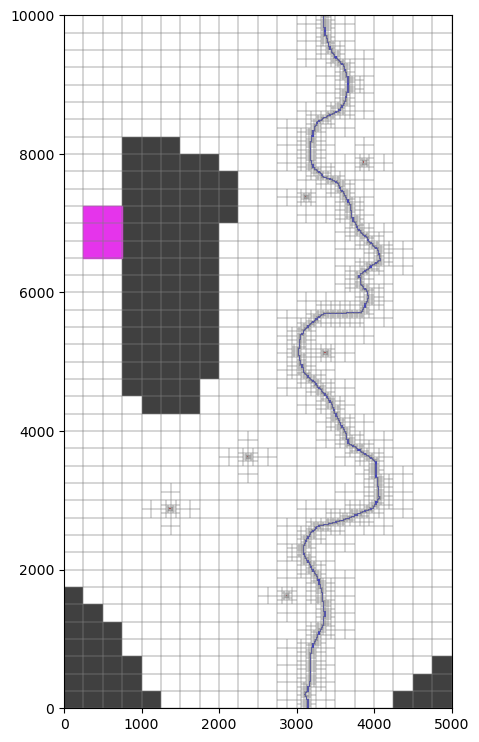

In [15]:
fig, ax = plt.subplots(figsize=(5, 9))
mm = flopy.plot.PlotMapView(gwf, layer=0, ax=ax)

mm.plot_bc('SFR', color="b", plotAll=True)
mm.plot_bc('WEL', plotAll=True)
mm.plot_inactive(alpha=0.75)

mm.plot_grid(lw=0.25, color='grey')

ax.fill(csx, csy, color='#e534eb');

### Get the model cells intersecting the contamination patch
The `GridIntersect` utility in Flopy has an `intersect` method that can find the model cells intersecting a set of points, lines, or polygons. Since this is a DISV grid, these will be ``cell2d`` values (that are the same across the model layers). Similarly, for a structured grid, `GridIntersect` would return row, column locations.

In [16]:
gx = GridIntersect(gwf.modelgrid)
results = gx.intersect(polygon, 'Polygon')
particle_start_nodes = results.cellids.astype(int)
particle_start_nodes

array([1352, 1353, 1459, 1460, 1581, 1582])

### Instantiate the MODFLOW 6 prt model
and discretization packages

In [17]:
prt_sim = flopy.mf6.MFSimulation(sim_name=prt_name, sim_ws=prt_model_ws)

# Instantiate the MODFLOW 6 temporal discretization package
flopy.mf6.modflow.mftdis.ModflowTdis(
    prt_sim,
    time_units="DAYS",
    nper=1,
    perioddata=[(1, 1, 1)],  # perlen, nstp, tsmult
)
prt = flopy.mf6.ModflowPrt(
    prt_sim, modelname=prt_name, model_nam_file=f"{prt_name}.nam"
)

# Instantiate the MODFLOW 6 prt discretization package
nlay, ncells_per_layer = gwf.dis.botm.array.shape
disv = flopy.mf6.ModflowGwfdisv(
    prt,
    nlay=nlay,
    ncpl=gwf.dis.ncpl.array,
    nvert=gwf.dis.nvert.array,
    length_units=gwf.dis.length_units.array,
    top=gwf.dis.top.array,
    botm=gwf.dis.botm.array,
    vertices=gwf.dis.vertices.array,
    cell2d=gwf.dis.cell2d.array,
    idomain=gwf.dis.idomain.array,
    xorigin=gwf.dis.xorigin.array,
    yorigin=gwf.dis.yorigin.array,
)

### Instantiate the MODFLOW 6 PRT Model Input Package.

**First make an ``izone`` array** with a zone number for each cell. The "izone" for the model cell will be reported in the PRT output, allowing us to more easily track where particles go, and where they ultimately discharge. For example, if we start particles at the water table, we can determine the contributing area for a stream or other boundary condition, by assigning an izone to those cells. One of the izone numbers can be designated as an ``istopzone``; particles entering this zone will be terminated regardless of whether the zone is a strong sink or not.

In this example, we'll assign different izone numbers to SFR and Well Package cells.

In [18]:
# start with a default zone of 0
izone_array = np.zeros((nlay, ncells_per_layer), dtype=int)

# get the locations of SFR cells
sfr_k, sfr_cellid = zip(*gwf.sfr.packagedata.array['cellid'])
sfr_k[:10], sfr_cellid[:10]

izones = {
    'wel': 1,
    'sfr': 2
}

**Assign SFR cells to zone 2**

In [19]:
izone_array[sfr_k, sfr_cellid] = izones['sfr']

**Assign wells to zone 1**
Using the stress period data. Note that in models with more than one stress period, different wells may be represented in different stress periods.

In [20]:
well_k = list()
well_cellid = list()
for per, recarray in gwf.wel.stress_period_data.data.items():
    well_k_per, well_cellid_per = zip(*recarray['cellid'])
    well_k.append(well_k_per)
    well_cellid.append(well_cellid_per)

izone_array[well_k, well_cellid] = izones['wel']

**Make the package**

In [21]:
flopy.mf6.ModflowPrtmip(prt,
                        porosity=0.1, 
                        izone=izone_array
                        )   

package_name = mip
filename = project-prt.mip
package_type = mip
model_or_simulation_package = model
model_name = project-prt

Block griddata
--------------------
porosity
{constant 0.1}

izone
Layer_1{internal}
(array([0, 0, 0, ..., 0, 0, 0], shape=(5108,), dtype=int32))
Layer_2{internal}
(array([0, 0, 0, ..., 0, 0, 0], shape=(5108,), dtype=int32))
Layer_3{internal}
(array([0, 0, 0, ..., 0, 0, 0], shape=(5108,), dtype=int32))



### Create the particle start data
From the nodes intersecting the polygon we made above, develop a DataFrame of particle start locations. For simplicity, we are just starting a single particle in each cell, but since the x and y are in local (model) coordinates, it would be fairly straightforward to start multiple particles in each cell on a finer spacing. 

In [22]:
# release particles at each row, column location
prt_start_x, prt_start_y = gwf.modelgrid.get_local_coords(
    gwf.modelgrid.xcellcenters[particle_start_nodes], 
    gwf.modelgrid.ycellcenters[particle_start_nodes])

prt_start_data = pd.DataFrame({
    'irptno': np.arange(len(prt_start_x.ravel())),
    'k': 0,
    'cell2d': particle_start_nodes,
    'xrpt': prt_start_x.ravel(),
    'yrpt': prt_start_y.ravel(),
    # start particles near top of saturation in cell with local_z=True
    'zrpt': particle_release_zrpt, #[1] * len(prt_i) ,
    # generic boundname for now;
    # could be used to differentiate source areas
    'boundname': [f'prt_{cell2d}' for cell2d in particle_start_nodes]
})
#prt_start_data = prt_particle_data
prt_start_data

,irptno,k,cell2d,xrpt,yrpt,zrpt,boundname
0,0,0,1352,375.0,7125.0,0.99,prt_1352
1,1,0,1353,625.0,7125.0,0.99,prt_1353
2,2,0,1459,375.0,6875.0,0.99,prt_1459
3,3,0,1460,625.0,6875.0,0.99,prt_1460
4,4,0,1581,375.0,6625.0,0.99,prt_1581
5,5,0,1582,625.0,6625.0,0.99,prt_1582


Alternatively, the [Modflow 6 Examples](https://github.com/MODFLOW-ORG/modflow6-examples/blob/develop/scripts/ex-prt-mp7-p02.py) illustrate functionality in Flopy to generate evenly spaced particles along cell faces for MODPATH models, and then convert the results to PRT format (if you can get it to work; search the MODFLOW 6 Examples repository for "``ModflowPrtprp``")

In [23]:
sd = flopy.modpath.CellDataType()
mp7_particle_data = flopy.modpath.NodeParticleData(subdivisiondata=[sd],
                                   nodes=list(particle_start_nodes))
prt_particle_data = list(mp7_particle_data.to_prp(prt.modelgrid))
prt_particle_data

[(0,
  (0, 1352),
  np.float64(291.6666666666667),
  np.float64(7041.666666666667),
  np.float64(25.157748113333334)),
 (1,
  (0, 1352),
  np.float64(375.0),
  np.float64(7041.666666666667),
  np.float64(25.157748113333334)),
 (2,
  (0, 1352),
  np.float64(458.33333333333337),
  np.float64(7041.666666666667),
  np.float64(25.157748113333334)),
 (3,
  (0, 1352),
  np.float64(291.6666666666667),
  np.float64(7125.0),
  np.float64(25.157748113333334)),
 (4,
  (0, 1352),
  np.float64(375.0),
  np.float64(7125.0),
  np.float64(25.157748113333334)),
 (5,
  (0, 1352),
  np.float64(458.33333333333337),
  np.float64(7125.0),
  np.float64(25.157748113333334)),
 (6,
  (0, 1352),
  np.float64(291.6666666666667),
  np.float64(7208.333333333334),
  np.float64(25.157748113333334)),
 (7,
  (0, 1352),
  np.float64(375.0),
  np.float64(7208.333333333334),
  np.float64(25.157748113333334)),
 (8,
  (0, 1352),
  np.float64(458.33333333333337),
  np.float64(7208.333333333334),
  np.float64(25.15774811333333

### Instantiate the MODFLOW 6 prt particle release point (PRP) package

**Notes:**

``local_z``—indicates that “zrpt” [in the particle start data] defines the local z coordinate of the release point within the cell, with value of 0
at the bottom and 1 at the top of the cell. If the cell is partially saturated at release time, the top of the cell is
considered to be the water table elevation (the head in the cell) rather than the top defined by the user.  

``istopzone``—integer value defining the stop zone number. If cells have been assigned IZONE values in the
GRIDDATA block, a particle terminates if it enters a cell whose IZONE value matches ISTOPZONE. An
ISTOPZONE value of zero indicates that there is no stop zone. The default value is zero. This way we can allow weak sinks but have exceptions where the particles will stop anyways.  

See the MODFLOW 6 Description of Input and Output for more options


In [24]:
flopy.mf6.ModflowPrtprp(
    prt,
    nreleasepts=len(prt_start_data),
    packagedata=prt_start_data.to_records(index=False).tolist(),
    local_z=True,
    boundnames=True,
    perioddata={0: ["FIRST"]},
    exit_solve_tolerance=1e-5,
    extend_tracking=True,
    #istopzone=istopzone
)

package_name = prp_0
filename = project-prt.prp
package_type = prp
model_or_simulation_package = model
model_name = project-prt

Block options
--------------------
boundnames
{internal}
(True)

exit_solve_tolerance
{internal}
(1e-05)

local_z
{internal}
(True)

extend_tracking
{internal}
(True)


Block dimensions
--------------------
nreleasepts
{internal}
(6)


Block packagedata
--------------------
packagedata
{internal}
(rec.array([(0, (0, 1352), 375., 7125., 0.99, 'prt_1352'),
           (1, (0, 1353), 625., 7125., 0.99, 'prt_1353'),
           (2, (0, 1459), 375., 6875., 0.99, 'prt_1459'),
           (3, (0, 1460), 625., 6875., 0.99, 'prt_1460'),
           (4, (0, 1581), 375., 6625., 0.99, 'prt_1581'),
           (5, (0, 1582), 625., 6625., 0.99, 'prt_1582')],
          dtype=[('irptno', '<i8'), ('cellid', 'O'), ('xrpt', '<f8'), ('yrpt', '<f8'), ('zrpt', '<f8'), ('boundname', 'O')]))


Block period
--------------------
perioddata
{internal}
(rec.array([('FIRST', None)],
         

### Instantiate the MODFLOW 6 PRT output control package

**Notes:**
PRT outputs a record each time a:

  0) particle was released
  1) particle exited a cell
  2) time step ended
  3) particle terminated
  4) particle entered a weak sink cell
  5) user-specified tracking time
    
The code below shows how to input user-specified tracking times to Flopy. Depending on the problem, this may not be necessary in a real-world context, as there may already be many records from particles exiting cells. Therefore, `tracktimes=None` (no user-specified times) is ultimately input to Flopy.

In [25]:
budget_record = [budgetfile_prt]
track_record = [trackfile_prt]
trackcsv_record = [trackcsvfile_prt]
# track positions every year for 100 years
track_nyears = 100
tracktimes = np.linspace(0, track_nyears*365.25, track_nyears+1)
flopy.mf6.ModflowPrtoc(
    prt,
    budget_filerecord=budget_record,
    track_filerecord=track_record,
    trackcsv_filerecord=trackcsv_record,
    ntracktimes=0,#len(tracktimes),
    tracktimes=None,#[(t,) for t in tracktimes],
    saverecord=[("BUDGET", "ALL")],
)

package_name = oc
filename = project-prt.oc
package_type = oc
model_or_simulation_package = model
model_name = project-prt

Block options
--------------------
budget_filerecord
{internal}
(rec.array([('project-prt.cbc',)],
          dtype=[('budgetfile', 'O')]))

track_filerecord
{internal}
(rec.array([('project-prt.trk',)],
          dtype=[('trackfile', 'O')]))

trackcsv_filerecord
{internal}
(rec.array([('project-prt.trk.csv',)],
          dtype=[('trackcsvfile', 'O')]))


Block dimensions
--------------------
ntracktimes
{internal}
(0)


Block period
--------------------
saverecord
{internal}
(rec.array([('BUDGET', 'ALL', None)],
          dtype=[('rtype', 'O'), ('ocsetting', 'O'), ('ocsetting_data', 'O')]))

printrecord
None


### Instantiate the PRT Flow Model Interface and Explicit Model Solution Packages



In [26]:
fmi_pd = [
    ("GWFHEAD", os.path.relpath(gwf_ws / headfile, prt_model_ws)), #Path(f"../{gwf_ws.name}/{headfile}")),
    ("GWFBUDGET", os.path.relpath(gwf_ws / budgetfile, prt_model_ws)) #Path(f"../{gwf_ws.name}/{budgetfile}")),
]
flopy.mf6.ModflowPrtfmi(prt, packagedata=fmi_pd)

# Create an explicit model solution (EMS) for the MODFLOW 6 prt model
ems = flopy.mf6.ModflowEms(
    prt_sim,
    filename=f"{prt_name}.ems",
)
sim.register_solution_package(ems, [prt.name])

### Write the PRT input files and run the model

In [27]:
prt_sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems_-1...
  writing model project-prt...
    writing model name file...
    writing package disv...


    writing package mip...
    writing package prp_0...
    writing package oc...
    writing package fmi...


In [28]:
prt_sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../../../../../.local/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 24 2025 11:41:46 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor

(True, [])

## Post-Process the MODFLOW and PRT Results


### Load MODFLOW and PRT results from the heads and pathline files

Load the MODFLOW heads

In [29]:
hobj = gwf.output.head()

In [30]:
hds = hobj.get_data()

Load the tracking CSV file

In [31]:
particle_data = pd.read_csv(prt_model_ws / trackcsvfile_prt)
particle_data.head()

,kper,kstp,imdl,iprp,irpt,ilay,icell,izone,istatus,ireason,trelease,t,x,y,z,name
0,1,1,1,1,1,1,1353,0,1,0,0.0,0.000000,375.000000,7125.0,29.843871,PRT_1352
1,1,1,1,1,1,1,1353,0,1,1,0.0,0.000000,375.000000,7125.0,29.650728,PRT_1352
2,1,1,1,1,1,1,1353,0,1,1,0.0,5600.493437,378.953010,7250.0,29.650728,PRT_1352
3,1,1,1,1,1,1,1198,0,1,1,0.0,11433.142331,402.113867,7500.0,29.417818,PRT_1352
4,1,1,1,1,1,1,1043,0,1,1,0.0,15357.870522,425.233970,7750.0,29.079618,PRT_1352


### Plot the heads and pathlines

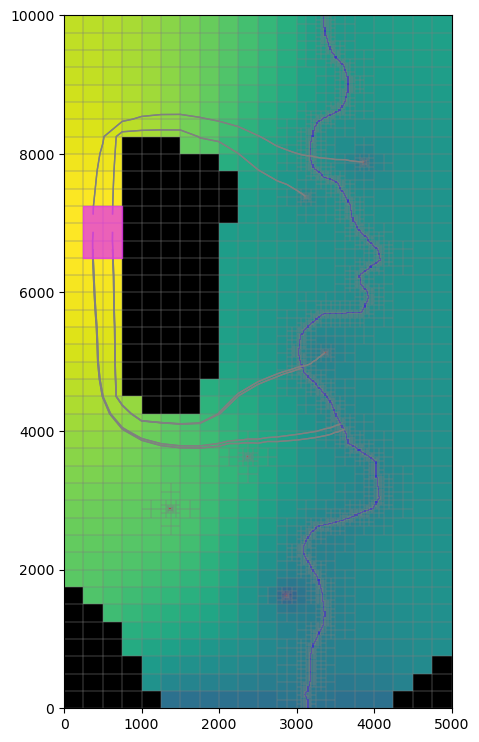

In [32]:
fig, ax = plt.subplots(figsize=(5, 9))
mm = flopy.plot.PlotMapView(model=gwf, layer=0, ax=ax)
mm.plot_array(hds, masked_values=[1e30])

mm.plot_bc('SFR', color='b', plotAll=True)
mm.plot_bc('WEL', plotAll=True)
mm.plot_ibound()
mm.plot_pathline(particle_data, layer='all', color='blue', lw=1)
mm.plot_grid(lw=0.2, color="0.5")

ax = plt.gca()
ax.fill(csx, csy, color='#e534eb', zorder=100, alpha=.75);

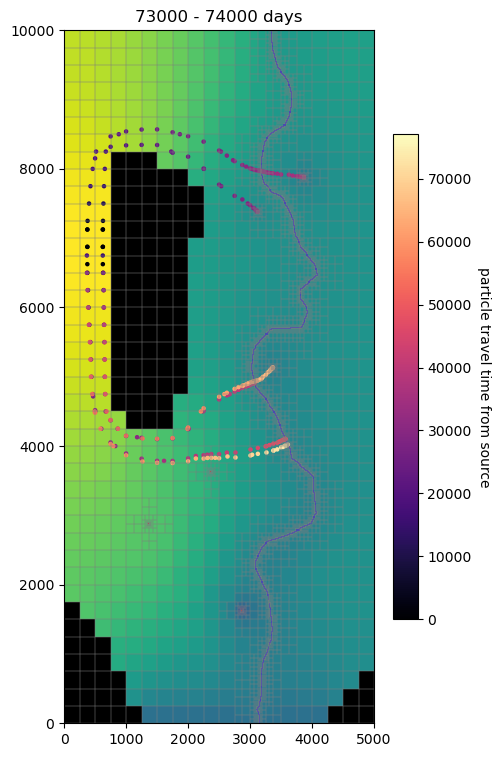

In [33]:
fig, ax = plt.subplots(figsize=(5, 9))

mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
mm.plot_array(hds, masked_values=[1e30])
mm.plot_bc('SFR', color='b', plotAll=True)
mm.plot_bc('WEL', plotAll=True)
mm.plot_ibound()
mm.plot_grid(lw=0.2, color="0.5")

df = particle_data
vmin, vmax = df['t'].min(), df['t'].max()

times = list(range(0, 74001, 1000))
for ix in range(1, len(times)):
    tmp = df[(df['t'] >= times[ix - 1]) & (df['t'] < times[ix])]
    s = ax.scatter(tmp['x'].values, tmp['y'].values, s=5, c=tmp['t'].values, 
                   vmin=vmin, vmax=vmax, cmap="magma")
    ax.set_title(f"{times[ix - 1]} - {times[ix]} days")
    if ix == 1:
        cbar = fig.colorbar(s, shrink=0.7)
        cbar.set_label('particle travel time from source', rotation=270, labelpad=14)
    display(fig)
    clear_output(wait=True)
    plt.pause(0.1)    

### Export the pathlines to a GeoPackage
GeoPackages allow for subsequent adding of layers; delete any pre-existing version of this GeoPackage to clear any pre-existing layers (often good practice in real projects).

In [34]:
output_geopackage = Path(prt_model_ws / 'Pathlines.gpkg')
output_geopackage.unlink(missing_ok=True)

#### First the PRT results DataFrame needs to be converted to a ``GeoDataFrame``
* In the real world, the model coordinates also need to be converted to real world coordinates. 
* We may also want to convert the travel times from the typical model time units of days to years.
* We may want to decompose the ``cellid`` into model layer (`k`) and ``cell2d`` (location in each layer, in this case), or layer, row column if the model has a regular structured grid.
* Finally, the GeoDataFrame will need a coordinate reference (to write to the GeoPackage) defining the coordinate reference system for the real-world coordinates (for example, UTM zone 15 north, represented by EPSG code 29615).

In [35]:
gwf.modelgrid.crs # no CRS attached

In [36]:
gwf.modelgrid.crs = 26915

In [37]:
df['t_years'] = df['t'] / 325.25
df['k'] = df['icell'] // ncells_per_layer
df['cell2d'] = df['icell'] % ncells_per_layer


In [38]:
x_crs, y_crs = gwf.modelgrid.get_coords(df['x'], df['y'])

gdf = gpd.GeoDataFrame(df, 
                       geometry=gpd.points_from_xy(x_crs, y_crs),
                       crs=gwf.modelgrid.crs)

#### write the GeoPackage
Write particles terminating in Well and SFR cells to separate layers

In [39]:
for package, izone in izones.items():
    layer_name = f"Particles going to {package.upper()} cells"
    izone_df = gdf.loc[gdf['izone'] == izone]
    izone_df.to_file(output_geopackage, index=False, layer=layer_name)

gdf.loc[gdf['izone'] == 0].to_file(
    output_geopackage, index=False, layer='All other particles')

/home/runner/micromamba/envs/pyclass-docs/lib/python3.11/site-packages/pyogrio/__init__.py:7: DeprecationWarning: The 'shapely.geos' module is deprecated, and will be removed in a future version. All attributes of 'shapely.geos' are available directly from the top-level 'shapely' namespace (since shapely 2.0.0).
  import shapely.geos  # noqa: F401


#### Add a layer with pathlines
The previous layers that we added to the GeoPackage were points representing particle locations at discrete points in time. We can also combine these in to pathlines (linestrings) to better visualize the paths taken by the particles. In real-world projects, for example where are particle is started in every cell of a large model, we may also have too many points to work with easily; showing a single pathline for each particle may be advantageous.

In [40]:
from shapely.geometry import LineString

# create set of pathlines with start and end information
# first group by particle
by_particle = gdf.sort_values(by=['irpt', 't']).groupby('irpt')
lines = by_particle.last()
lines.crs = gdf.crs  # CRS isn't retained in groupby
lines.rename(columns={'k': 'end_k', 'cell2d': 'end_cell2d'}, inplace=True)
line_starts = by_particle.first()
lines['start_k'] = line_starts['k']
lines['start_cell2d'] = line_starts['cell2d']

# above we sorted the results by particle and then time
# use the .agg method on the grouby object to create a LineString
# from the (sorted) sequence of points defining each particle path
linestring_geoms = by_particle['geometry'].agg(lambda x: LineString(x))
lines['geometry'] = linestring_geoms

In [41]:
for package, izone in izones.items():
    layer_name = f"Pathlines going to {package.upper()} cells"
    izone_df = lines.loc[lines['izone'] == izone]
    izone_df.to_file(output_geopackage, index=False, layer=layer_name)
izone_df.loc[izone_df['izone'] == 0].to_file(
    output_geopackage, index=False, layer='All other pathlines')

### Plot pathlines going to SFR and WEL cells

/tmp/ipykernel_12275/3686669298.py:10: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  izone_df.plot(ax=ax, ec=line_colors[package],


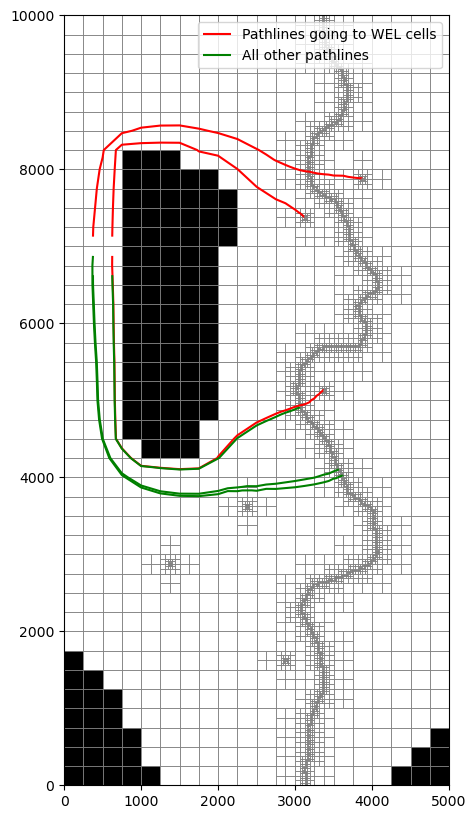

In [42]:
fig, ax = plt.subplots(figsize=(6, 10))
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
pmv.plot_grid(lw=0.5)
line_colors = {
    'sfr': 'b',
    'wel': 'r'
}
for package, izone in izones.items():
    izone_df = lines.loc[lines['izone'] == izone]
    izone_df.plot(ax=ax, ec=line_colors[package],
                  label=f'Pathlines going to {package.upper()} cells')
lines.loc[lines['izone'] == 0].plot(
    ax=ax, ec='g',
    label=f'All other pathlines')
pmv.plot_ibound()
pmv.ax.legend()

In [43]:
lines

,kper,kstp,imdl,iprp,ilay,icell,izone,istatus,ireason,trelease,...,x,y,z,name,t_years,end_k,end_cell2d,geometry,start_k,start_cell2d
irpt,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,3,11220,1,5,3,0.0,...,3867.121145,7882.863742,7.757005,PRT_1352,108.484092,2,1004,"LINESTRING (375 7125, 375 7125, 378.953 7250, ...",0,1353
2,1,1,1,1,3,11437,1,5,3,0.0,...,3117.167488,7382.776291,7.732968,PRT_1353,91.056153,2,1221,"LINESTRING (625 7125, 625 7125, 627.449 7250, ...",0,1354
3,1,1,1,1,3,13271,0,2,3,0.0,...,3618.667133,4015.860878,5.953580,PRT_1459,236.930790,2,3055,"LINESTRING (375 6875, 375 6875, 367.643 6750, ...",0,1460
4,1,1,1,1,3,12779,1,5,3,0.0,...,3367.009282,5132.899285,6.454878,PRT_1460,204.729294,2,2563,"LINESTRING (625 6875, 625 6875, 623.814 6750, ...",0,1461
5,1,1,1,1,3,13249,0,2,3,0.0,...,3568.882110,4102.309981,6.198813,PRT_1581,147.730434,2,3033,"LINESTRING (375 6625, 375.698 6500, 385.798 62...",0,1582
6,1,1,1,1,3,12863,0,2,3,0.0,...,3065.795508,4907.706966,6.184416,PRT_1582,127.007399,2,2647,"LINESTRING (625 6625, 628.34 6500, 636.278 625...",0,1583


### Why don't the SFR Pathlines end up in `izone=2`?
Clearly, these particles are terminating in SFR cells.

The ending `icell` values for these lines are in `izone=2`

In [44]:
izone_array.flat[(lines.loc[lines['izone'] == 0, 'icell'] -1).values]

array([2, 2, 2])

And the ending layer and cell2d locations for these lines are in the SFR Package:

In [45]:
sfr_k, sfr_cell2d = zip(*gwf.sfr.packagedata.array['cellid'])
all(lines.loc[lines['izone'] == 0, 'end_cell2d'].isin(np.array(sfr_cell2d)+1))

True

Note also that running this exercise without specifying `iflowface` (setting `write_iflowface=False` above), we get the expected result of the pathlines that end in SFR cells having `izone=2` in their last record in the PRT results.

### References
Abrams, D., Haitjema, H. and Kauffman, L. (2013), On Modeling Weak Sinks in MODPATH. Groundwater, 51: 597-602. https://doi.org/10.1111/j.1745-6584.2012.00995.x